# <span style="color:darkgreen">DATSCIW261 ASSIGNMENT 9</span>
#### MIDS UC Berkeley, Machine Learning at Scale

<b>AUTHORS</b> : 
    - Charles Maalouf
    - Rajesh Thallam
<b>EMAIL</b>  : cmaalouf@berkeley.edu, rajesh.thallam@ischool.berkeley.edu <br>
<b>WEEK</b>   : 10 <br>
<b>DATE</b>   : 10-Nov-15

***

<h2><span style="color:dodgerblue;font:12px">HW9.0</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Short answer questions</b></span>

<span style="color:CornflowerBlue ">a. What is PageRank and what is it used for in the context of web search </span><br>

PageRank is a network analysis algorithm that assigns a score to each node of the graph, with the purpose of measuring the relative importance of each node in the context of that specific graph. PageRank is what Google uses to determine the importance of a web page. It's one of many factors used to determine which pages appear in web search. 

<span style="color:CornflowerBlue">b. What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the steady stade distibuton?</span><br>

To leverage Markov Chains for computing page rank in a graph, we need to insure the graph is irreducible and there are no dangling nodes. To solve this issue g nodes (which is 0) in the adjacency matrix with 1/N, where N is the number of non-dangling nodes and by a damping factor for teleportation. The modified page rank is as follows

\begin{equation}
PR(n) = \alpha \left(\frac{1}{|G|}\right) + (1-\alpha)\left( \frac{m}{|G|} + \sum_{i \in L(n)} { \frac{PR(i)}{C(i)}} \right)
\end{equation}

<span style="color:CornflowerBlue">OPTIONAL: <br> c. In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)

There are couple of ways to ensure irreducible property

- Nodes not reachable from the non-zero nodes in the damping vector should be removed
- Instead of uniform damping vector, consider a non-uniform damping vector by introducing damping factor b (beta). With this approach, nodes need not be deleted
    - If beta > 0.5, PageRank is topic-sensitive, and 
    - If beta < 0.5, the PageRank is anti-topic-sensitive. 

\begin{equation}
PR_j(n) =  {\alpha \left(\frac{1}{|T_j|}\right)} + (1-\alpha)\left( \frac{m}{|G|} + \sum_{i \in L(n)} { \frac{PR_j(i)}{C(i)}} \right)
\end{equation}
where j is the topic and |Tj| is the number of nodes in the topic.

<span style="color:firebrick; font-size: 120%;"><b>Addendum questions from HW7</b></span><br>

<span style="color:CornflowerBlue;font-size: 120%;"><b>HW 7.5.1</b></span><br>
<span style="color:CornflowerBlue">a. Can we utilize combiners in the HW 7 to perform the shortest path implementation? </span><br>

Yes: If we have one mapper that end up adding the same node to the queue, the combiner can act like a reducer on a single node, reducing computational burden on the reducer and decreases the data transfer on the network. 

In the implementation of breadth first search algorithm to find shortest distance combiners can be used to calculate minimum distance to reachable nodes if several nodes point to the same target in a single mapper. However, combiner performance is dependent on how well the network is connected. If the nodes are connected densely then combiners can improve performance otherwise they would be an overhead to the process. 

<span style="color:CornflowerBlue">b. Does order inversion help with the HW 7 shortest path implementation? </span><br>

Order inversion pattern is useful when intermediate results are needed before processing the entire data. For the shortest path computation order inversion can be used to minimize the work done by reducer by determining the shortest distance and discarding the remaining distances (only distances not the graph structures) as order inversion ensures that the first value in the reducer is the shortest distance by sorting the values in ascending order.

***

<span style="color:firebrick; font-size: 120%;"><b>MRJob Configuration</b></span><br>

**NOTE:** For couple of runs towards the end of assignment submission we had to spun 3 m1.large instances to quickly check some intermediate results. These were run with job pooling enabled and were completely utilized. Otherwise default configuration is as shown below.

In [28]:
!cat /home/rt/.mrjob.conf | awk -F":" '{if ( $1 ~ /key/ ) { print $1": XXXX"} else { print $0} }'

runners:
    emr:
        aws_access_key_id: XXXX
        aws_secret_access_key: XXXX
        ec2_instance_type: m1.medium
        aws_region: sa-east-1
        ec2_master_instance_type: m1.medium
        num_ec2_instances: 11
        enable_emr_debugging: true
        s3_endpoint: s3.amazonaws.com 
        s3_log_uri: s3://ucb-mids-mls-rajeshthallam/tmp/logs/
        s3_scratch_uri: s3://ucb-mids-mls-rajeshthallam/tmp/
        bootstrap:
        - sudo apt-get install -y python-pip || sudo yum install -y python-pip
        - sudo pip install boto mr3po



***

<h2><span style="color:dodgerblue;font:12px">HW9.1</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>MRJob implementation of basic PageRank</b></span>

<span style="color:CornflowerBlue ">Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7). Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1). As you build your code, use the [test data](s3://ucb-mids-mls-networks/PageRank-test.txt) with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85). </span><br>

<span style="color:cornflowerblue; font-size: 120%;"><b>Page Rank Preprocessor</b> - Count number of nodes</span><br>

Determine number of nodes (number of web pages) to initialize page rank

In [20]:
%%writefile NodeEdgeCounts.py
#!/usr/bin/env python
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRNodeEdgeCounts(MRJob):

    def steps(self):
        return (
                [MRStep(
                    mapper = self.mapper,
                    combiner = self.combiner,
                    reducer = self.reducer),
                 MRStep(reducer = self.reducer_sum)
                ]
        )
    
    def mapper(self, _, line):
        v, edges = line.strip().split('\t')
        edges = eval(edges)
        for edge in edges:
            yield edge, 1
        yield v, 1

    def combiner(self, edge ,count):
        yield edge, max(count)
            
    def reducer(self, edge ,count):
        yield None, max(count)

    def reducer_sum(self, edge ,count):
        yield 'edge_count', sum(count)
        
if __name__ == '__main__':
    MRNodeEdgeCounts.run()

Overwriting NodeEdgeCounts.py


In [21]:
!./NodeEdgeCounts.py ./PageRank-test_indexed.txt -q --no-strict-protocol

"edge_count"	11


In [22]:
%%writefile run_data_analysis.py
#!/usr/bin/env python

from NodeEdgeCounts import MRNodeEdgeCounts
import time
import sys

SOURCE = sys.argv[1]
RUNMODE = sys.argv[2]

start_time = time.time()
print "processing file {}".format(SOURCE)

mr_job = MRNodeEdgeCounts(args=[SOURCE, '-r', RUNMODE, '--pool-emr-job-flows', '--max-hours-idle', '1'])
with mr_job.make_runner() as runner:
    runner.run()
    nodes = []
    for line in runner.stream_output():
        nodes.append(int(line.split('\t')[1]))

    node_count = sum(nodes)

end_time = time.time()
print "Time taken to do analysis = {:.2f} seconds".format(end_time - start_time)

print "Number of nodes = {}".format(node_count)

f = open('./node_count.txt', 'w+')
print >>f, node_count
f.close()

Overwriting run_data_analysis.py


<span style="color:cornflowerblue; font-size: 120%;">Running locally</span><br>

In [23]:
!aws s3 cp s3://ucb-mids-mls-networks/PageRank-test_indexed.txt ./PageRank-test_indexed.txt
!./run_data_analysis.py ./PageRank-test_indexed.txt local

A client error (403) occurred when calling the HeadObject operation: Forbidden
Completed 1 part(s) with ... file(s) remaining
processing file ./PageRank-test_indexed.txt
No handlers could be found for logger "mrjob.runner"
Time taken to do analysis = 2.77 seconds
Number of nodes = 11


In [24]:
N = open('./node_count.txt').read().strip()
print N

11


In [25]:
!cat ./PageRank-test_indexed.txt

2	{'3': 1}
3	{'2': 1}
4	{'1': 1, '2': 1}
5	{'4': 1, '2': 1, '6': 1}
6	{'2': 1, '5': 1}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 1}


<span style="color:cornflowerblue; font-size: 120%;"><b>Implementation Approach</b></span><br>

*Ref: Data-Intensive Text Processing with MapReduce, pg.104-106*

**1. m_pagerank_init: ** Mapper to initialize each node with 1/|N|

     input: node, out_links
     emits: node, (out_links | pr)

**2. m_distribute: ** For each node in the mapper compute how much PageRank mass needs to be distributed to its neighbors (i.e., nodes on the adjacency list). Each piece of the PageRank mass is emitted as the value, keyed by the node ids of the neighbors. For the dangling nodes, follow order inversion pattern with key as 'dangling' (or could be \*) with page rank of the node. In the shuffle-sort phase, framework groups values (piece of PageRank mass) passed along the graph edges by destination node (i.e., all edges that point to the same node). This ensures the dangling nodes mass reaches only one reducer (and then broadcasted by reducer)

    (i)    Distributes mass to the outgoing links
           emit: target_node, pr / len(out_links)
    (ii)   If the node is dangling i.e. no outgoing links
           emit: 'dangling', pr
    (iii)  recover graph structure
           emit: node, out_links

**3. r_combine_mass: ** In the reducer, the PageRank mass contributions from all incoming edges are aggregated to arrive at the updated PageRank value for each node. 
    (i)   Combine the probabilities
           M += pr_out_link
           emit node, (out_links | M)

For the dangling nodes, the loss is distributed to all the nodes by emitting the loss along with the node.

    (ii)   if the node is dangling, redistribute the loss to all the nodes in the graph

           loss = sum(pr_out_links)
           for node in range(1, N + 1):
                emit node, loss

           at this point all the dangling nodes mass comes to one reducer and this is broadcasted to other nodes. 

**4. r_update_pagerank: ** The second reducer (in step 2) accounts for the random jump factor (teleportation) and aggregates the loss due to the dangling node,

    (i)    apply the page rank computation with teleportation factor
           pr_new = a * (1/N) + (1-a) * (loss/N + float(pr))
           emit node, out_links | pr_new
           
Steps 2 to 4 are repeated for **num-iterations** number of iterations until convergence is reached

In [1]:
%%writefile pageRank.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class MRPageRank(MRJob):

    def steps(self):
        return (
                [MRStep(mapper=self.m_pagerank_init)] +
                [MRStep(mapper = self.m_distribute, reducer = self.r_combine_mass),
                 MRStep(reducer = self.r_update_pagerank)
                ] * self.options.num_iterations
        )

    # set command line option to accept start and end node
    def configure_options(self):
        super(MRPageRank, self).configure_options()
        self.add_passthrough_option('--num-iterations', default=10, type=int, help='number of iterations to compute stable pagerank')
        self.add_passthrough_option('--N', default=None, type=float, help='total number of webpages (or nodes)')
        self.add_passthrough_option('--d', default=0.85, type=float, help='dampening factor')

    #    pagerank_init initializes each node with 1/|G|,
    #    where |G| is number of nodes in the entire graph
    #    (determined in a pre-processing phase)
    def m_pagerank_init(self, _, line):
        node, out_links = line.split('\t')
        pr = 1 / self.options.N
        yield node, out_links + "|" + str(pr)

    #   distribute mass to the outgoing links
    def m_distribute(self, node, pr_out_links):
        # parse input to read page rank of the outgoing links
        out_links, pr = map(ast.literal_eval, pr_out_links.split('|'))
        
        # vanilla page rank
        if len(out_links) > 0:
            pr_new = pr / len(out_links)

            for out_link in out_links:
                yield out_link, pr_new

        # if the node is for dangling (i.e. no outgoing link),
        # emit the loss to redistribute to all the incoming
        # links to the dangling node
        if len(out_links) == 0:
            yield 'dangling', pr

        # recover graph structure
        yield node, out_links

    # update pagerank by combining the mass
    def r_combine_mass(self, node, pr_out_links):

        # if the node is dangling, redistribute the loss
        # to all the nodes in the graph
        if node == 'dangling':
            loss = sum(pr_out_links)
            for n in range(1, int(self.options.N) + 1):
                yield str(n), loss
        # else combine the mass for the node
        else:
            M = 0
            out_links = {}

            for pr_out_link in pr_out_links:
                if type(pr_out_link) == dict:
                    out_links = pr_out_link
                elif type(pr_out_link) == float:
                    M += pr_out_link

            yield node, str(out_links) + "|" + str(M)
            
    def r_update_pagerank(self, node, pr_out_links):
        loss = 0.0
        pr = 0.0
        out_links = {}

        # teleportation factor
        a = 1 - self.options.d
        N = self.options.N

        for pr_out_link in pr_out_links:
            if type(pr_out_link) == float:
                loss = pr_out_link
            else:
                out_links, pr = map(ast.literal_eval, pr_out_link.split('|'))

        pr_new = a * (1/N) + (1-a) * (loss/N + float(pr))

        yield node, str(out_links) + "|" + str(round(pr_new, 5))

if __name__ == '__main__':
    MRPageRank.run()

Overwriting pageRank.py


<span style="color:cornflowerblue; font-size: 120%;"><b>Driver script to run on local<b></span><br>

In [3]:
#!/usr/bin/python
import time

# read source file, start and end nodes
SOURCE = './PageRank-test_indexed.txt'
N = 11
D = 0.85
ITER = 100

start_time = time.time()
print "processing file {}".format(SOURCE)

# run on local
!./pageRank.py {SOURCE} --N={N} --d={D} --num-iterations={ITER} -q --no-strict-protocol > hw9_1.out

end_time = time.time()

print "Time taken to find page rank of the network = {:.2f} seconds".format(end_time - start_time)

print "Pagerank of the graph is"
!sed 's/\"//g' ./hw9_1.out | sort -k1n > pagerank_local.out
!cat pagerank_local.out

processing file ./PageRank-test_indexed.txt
Time taken to find page rank of the network = 3.53 seconds
Pagerank of the graph is
1	{}|0.03278
2	{'3': 1}|0.3844
3	{'2': 1}|0.34293
4	{'1': 1, '2': 1}|0.03909
5	{'2': 1, '4': 1, '6': 1}|0.08089
6	{'2': 1, '5': 1}|0.03909
7	{'2': 1, '5': 1}|0.01617
8	{'2': 1, '5': 1}|0.01617
9	{'2': 1, '5': 1}|0.01617
10	{'5': 1}|0.01617
11	{'5': 1}|0.01617


<span style="color:cornflowerblue; font-size: 120%;"><b>Driver script to run on EMR<b></span><br>

In [259]:
%%writefile run_pagerank_emr.py
#!/usr/bin/python
import time
import sys
from pageRank import MRPageRank

# read source file, start and end nodes
SOURCE = sys.argv[1]
TARGET = sys.argv[2]
N = sys.argv[3]
ITER = sys.argv[4]

D = "0.85"

start_time = time.time()
print "processing file {}".format(SOURCE)

# run on emr
mr_job = MRPageRank(
    args=[
        SOURCE, 
        '--N', N, 
        '--d', D, 
        '--num-iterations', ITER, 
        '-r', 'emr', 
        '--pool-emr-job-flows', 
        '--max-hours-idle', '1', 
        '--pool-name', 'jobpool_hw9_rt', 
        '--output-dir', TARGET, 
        '-q', 
        '--no-output', 
        '--no-strict-protocol',
        '--num-ec2-instances=4',
        '--ec2-instance-type', 'm1.large'
    ])

with mr_job.make_runner() as runner: 
    runner.run()

end_time = time.time()

print "Time taken to find page rank of the network = {:.2f} seconds".format(end_time - start_time)

Overwriting run_pagerank_emr.py


In [169]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw9/toy/ --recursive

# run EMR
# <script> <source> <target> <number-of-nodes> <number-of-iterations>
!./run_pagerank_emr.py './PageRank-test_indexed.txt' 's3://ucb-mids-mls-rajeshthallam/hw9/toy/' 11 1

delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/_SUCCESS
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00009
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00010
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00000
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00001
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00002
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00006
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00005
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00004
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00003
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00007
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00011
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00013
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00008
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00014
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00015
delete: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00016

**Downloading results from EMR and displaying page rank of the network**

In [63]:
!aws s3 cp s3://ucb-mids-mls-rajeshthallam/hw9/toy/ ./data/output/toy --recursive

download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00002 to data/output/toy/part-00002
download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/_SUCCESS to data/output/toy/_SUCCESS
download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00001 to data/output/toy/part-00001
download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00004 to data/output/toy/part-00004
download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00005 to data/output/toy/part-00005
download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00006 to data/output/toy/part-00006
download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00000 to data/output/toy/part-00000
download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00007 to data/output/toy/part-00007
download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00008 to data/output/toy/part-00008
download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00011 to data/output/toy/part-00011
download: s3://ucb-mids-mls-rajeshthallam/hw9/toy/part-00009 to data/output/toy/part-00009
dow

In [64]:
!cat ./data/output/toy/part-* | sed 's/\"//g' | sort -k1n

1	{}|0.03288
2	{'3': 1}|0.35235
3	{'2': 1}|0.35614
4	{'1': 1, '2': 1}|0.03935
5	{'2': 1, '4': 1, '6': 1}|0.08104
6	{'2': 1, '5': 1}|0.03935
7	{'2': 1, '5': 1}|0.0162
8	{'2': 1, '5': 1}|0.0162
9	{'2': 1, '5': 1}|0.0162
10	{'5': 1}|0.0162
11	{'5': 1}|0.0162


***

<h2><span style="color:dodgerblue;font:12px">HW9.2</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Exploring PageRank teleportation and network plots</b></span>

<span style="color:CornflowerBlue ">In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha, so that each nodes radius is proportional to its PageRank score. In particular you should do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1].</span><br>

<span style="color:cornflowerblue; font-size: 120%;"><b>Driver script to get plot data</b></span>

In [65]:
%%writefile explore_teleport_driver.py
#!/usr/bin/python
from pageRank import MRPageRank
import time

SOURCE = './PageRank-test_indexed.txt'
N = "11"
ITER = "10"
D = [0, 0.25, 0.5, 0.75, 0.85, 1]
    
for d in D:
    print "processing file {} with d = {}".format(SOURCE, d)
    start_time = time.time()
    # run on emr
    mr_job = MRPageRank(
        args=[
            SOURCE, 
            '--N', N, 
            '--d', d, 
            '--num-iterations', ITER, 
            '--output-dir', './data/output/toy/plots/plot-{}'.format(d), 
            '-q', 
            '--no-output', 
            '--no-strict-protocol'
        ])
    
    with mr_job.make_runner() as runner: 
        runner.run()
        
    end_time = time.time()
    print "Time taken = {:.2f} seconds for d = {}".format(end_time - start_time, d)

Overwriting explore_teleport_driver.py


In [66]:
!./explore_teleport_driver.py

processing file ./PageRank-test_indexed.txt with d = 0
Time taken = 0.29 seconds for d = 0
processing file ./PageRank-test_indexed.txt with d = 0.25
Time taken = 0.30 seconds for d = 0.25
processing file ./PageRank-test_indexed.txt with d = 0.5
Time taken = 0.30 seconds for d = 0.5
processing file ./PageRank-test_indexed.txt with d = 0.75
Time taken = 0.31 seconds for d = 0.75
processing file ./PageRank-test_indexed.txt with d = 0.85
Time taken = 0.32 seconds for d = 0.85
processing file ./PageRank-test_indexed.txt with d = 1
Time taken = 0.32 seconds for d = 1


<span style="color:cornflowerblue; font-size: 120%;"><b>Plotting network graphs for various d (teleportation factor)</b></span>

In [54]:
%matplotlib inline
import networkx as nx
import ast
from matplotlib import pyplot as plt

def draw_graph(graph, pr, d, labels=None):
    plt.figure(figsize=(10, 10))

    # initialize graph
    DG = nx.DiGraph()

    # add edges
    for edge in graph:
        DG.add_edge(edge[0], edge[1])
   
    node_size = [pr[n]*30000 for n in DG.nodes()]

    graph_pos = nx.circular_layout(DG)

    # set labels and colors
    labels = {}
    node_colors = []

    print "Network graph with d = {}".format(d)
    
    for node in DG.nodes():
        labels[node] = '{}\n{}'.format(node, pr[node])
        if pr[node] <= 0.01:
            node_colors.append('violet')
        if pr[node] > 0.01 and pr[node] <= 0.05:
            node_colors.append('green')
        if pr[node] > 0.05 and pr[node] <= 0.1:
            node_colors.append('yellow')
        elif pr[node] > 0.1:
            node_colors.append('red')

    # draw graph
    nx.draw_networkx_nodes(DG, graph_pos, node_size = node_size, alpha = 0.3, node_color = node_colors)
    nx.draw_networkx_edges(DG, graph_pos, width = 0.3, alpha = 1, edge_color = 'black')
    nx.draw_networkx_labels(DG, graph_pos, labels=labels, font_size = 12)

    # show graph
    plt.title("PageRank with d={}".format(d))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def driver(f, d):
    edges = []
    prob = {}

    for line in open(f).read().strip().split('\n'):
        node, pr_out_links = line.split('\t')
        node = int(node.replace('"', ''))
        out_links, pr = map(ast.literal_eval, pr_out_links.strip('"').split('|'))
        edges.extend([(node, int(n)) for n in out_links.keys()])
        prob[node] = pr
        
    draw_graph(edges, prob, d)

Network graph with d = 0


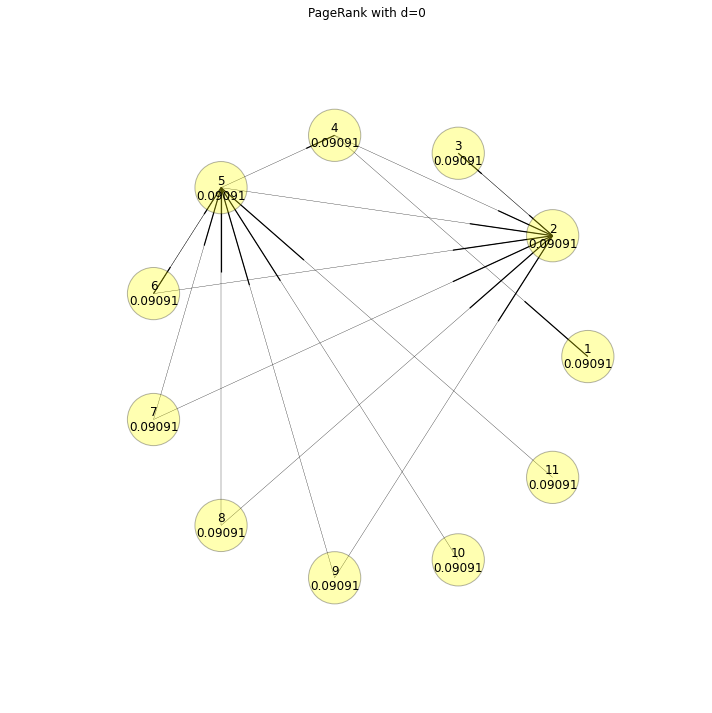

Network graph with d = 0.25


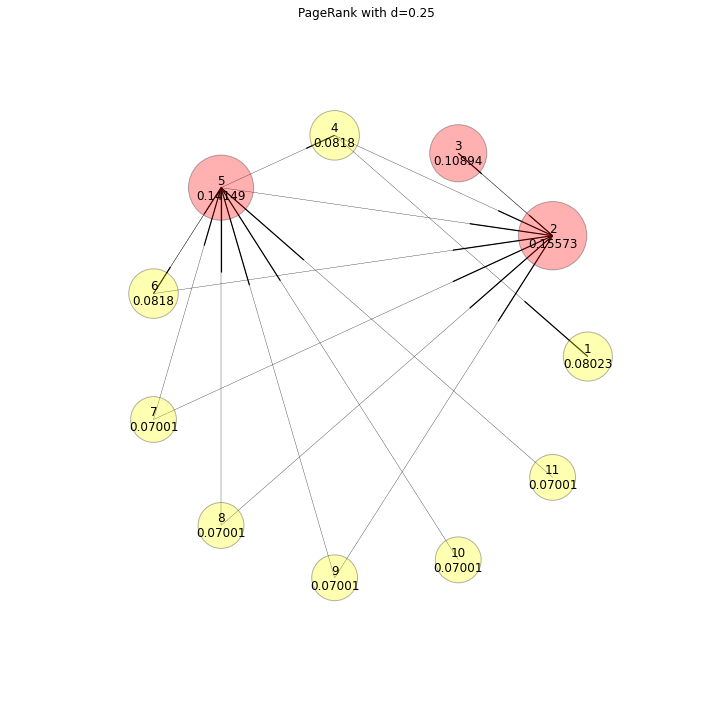

Network graph with d = 0.5


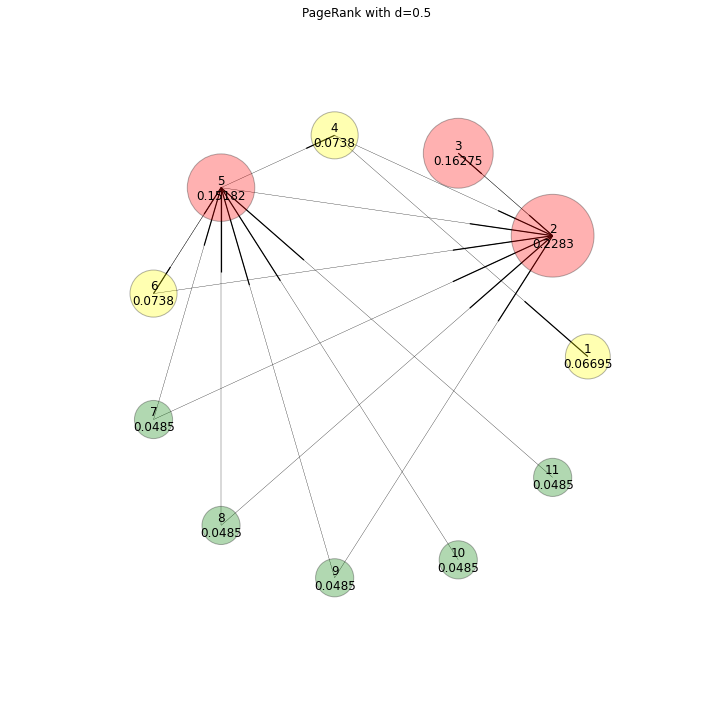

Network graph with d = 0.75


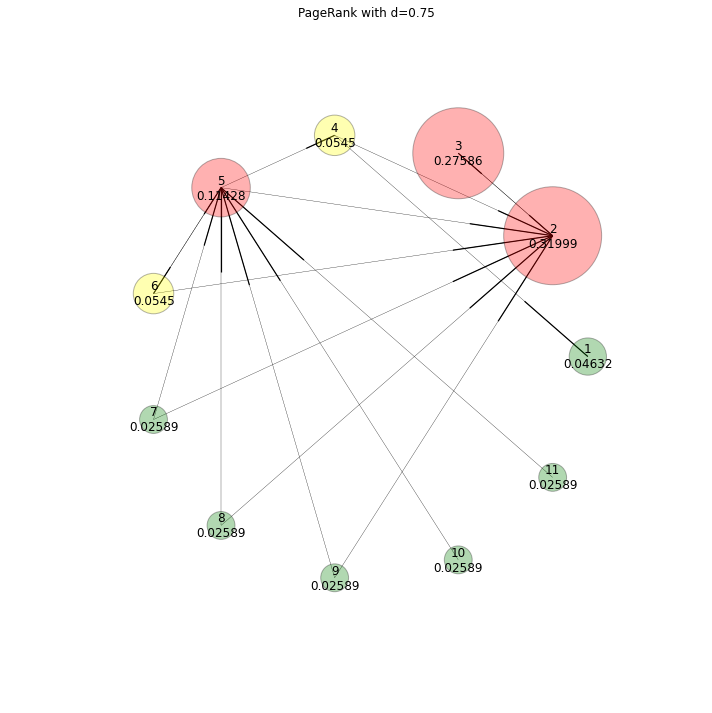

Network graph with d = 0.85


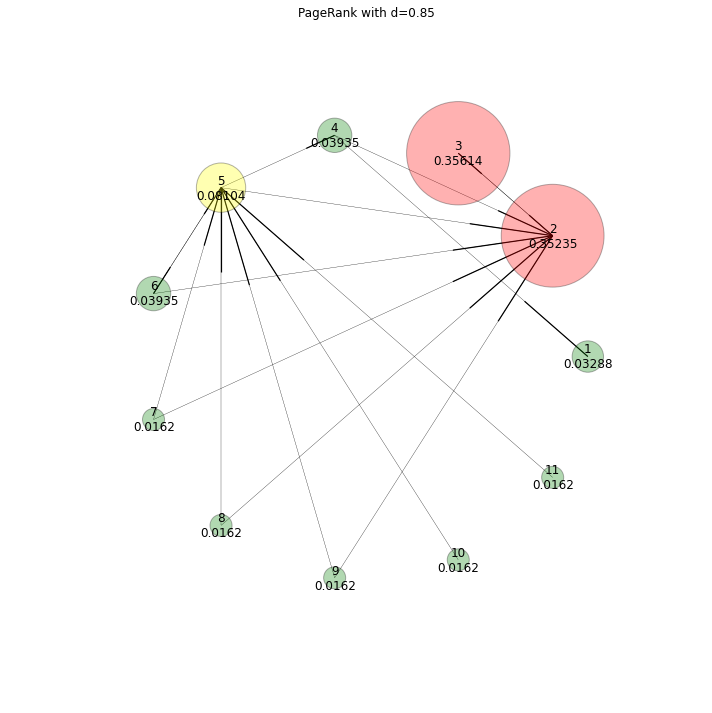

Network graph with d = 1


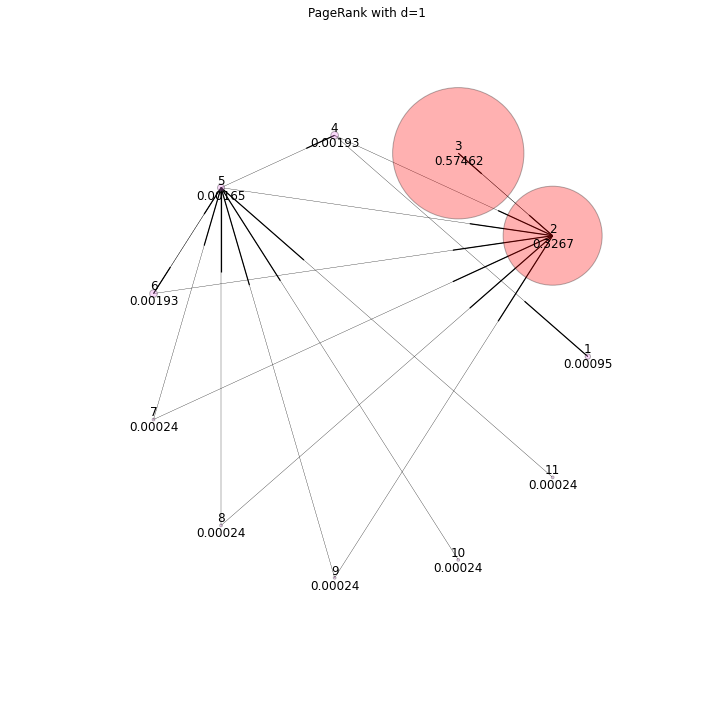

In [55]:
D = [0, 0.25, 0.5, 0.75, 0.85, 1]
    
for d in D:
    f = './data/output/toy/plots/plot-{}/part-00000'.format(d)
    driver(f, d)

***

<h2><span style="color:dodgerblue;font:12px">HW9.3</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Applying PageRank to the Wikipedia hyperlinks network</b></span>

<span style="color:CornflowerBlue ">Run your PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with alpha = 0.85). Run your PageRank implementation on the Wikipedia dataset for 50 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15). Have the top 100 ranked pages changed? Comment on your findings. Plot both 100 curves.</span><br>

<span style="color:firebrick; font-size: 120%;"><b>PageRank implementation on the Wikipedia dataset for 10 iterations</b></span><br>

**From HW7, there are total 15192277 web pages in the wiki data set **

In [ ]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter10_run2/ --recursive

# run EMR
# <script> <source> <target> <number-of-nodes> <number-of-iterations>
!./run_pagerank_emr.py \
's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt' \
's3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter10_run2/' \
15192277 \
10

In [ ]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter50/ --recursive

# run EMR
# <script> <source> <target> <number-of-nodes> <number-of-iterations>
!./run_pagerank_emr.py \
's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt' \
's3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter50/' \
15192277 \
50

In [262]:
%%writefile PageRankTopN.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast,sys

class MRPageRankTopN(MRJob):
    def steps(self):
        return [
            MRStep(
                mapper_init = self.init,
                mapper = self.m_rank,
                mapper_final = self.final,
                reducer_init = self.init,
                reducer = self.r_rank,
                reducer_final = self.final,
                jobconf={
                    'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                    'mapred.text.key.comparator.options': '-k1,1rn',
                    'mapred.reduce.tasks': 1
                }
            )]
    
    # set command line option to accept start and end node
    def configure_options(self):
        super(MRPageRankTopN, self).configure_options()
        self.add_passthrough_option('--N', default=100, type=int, help='top N')
    
    def init(self):
        self.N = self.options.N
        self.top_N = []
    
    def m_rank(self, _, line):
        node, pr_out_links = line.split("\t")
        node = node.replace("\"", "")
        out_links, pr = map(ast.literal_eval, pr_out_links.replace("\"","").split('|'))
        
        self.top_N.append((pr, node))
        if len(self.top_N) > self.N:
            self.top_N.sort(key=lambda x: -float(x[0]))
            self.top_N = self.top_N[:self.N]
            
    def r_rank(self, pr, nodes):
        for node in nodes:
            self.top_N.append((float(pr), node))
        if len(self.top_N) > self.N:
            self.top_N.sort(key=lambda x: -float(x[0]))
            self.top_N = self.top_N[:self.N]
            
    def final(self):
        for pr, node in self.top_N:
            yield pr, node
    
if __name__ == '__main__':
    MRPageRankTopN.run()

Overwriting PageRankTopN.py


** Test top N job locally**

In [247]:
!./PageRankTopN.py ./pagerank_local.out --N=5 -q --no-strict-protocol

0.03935	"4"
0.03935	"6"
0.08104	"5"
0.35235	"2"
0.35614	"3"


In [264]:
%%writefile run_pageranktopN_emr.py
#!/usr/bin/python
import time
import sys
from PageRankTopN import MRPageRankTopN

# read source file, start and end nodes
SOURCE = sys.argv[1]
TARGET = sys.argv[2]
N = sys.argv[3]

start_time = time.time()
print "processing file {}".format(SOURCE)

# run on emr
mr_job = MRPageRankTopN(
    args=[
        SOURCE, 
        '--N', N, 
        '-r', 'emr', 
        '--pool-emr-job-flows', 
        '--max-hours-idle', '1', 
        '--pool-name', 'jobpool_hw9_rt', 
        '--output-dir', TARGET, 
        '-q', 
        '--no-output', 
        '--no-strict-protocol',
        '--emr-job-flow-id', 'j-1QGK4L3WHVE4N'
    ])

with mr_job.make_runner() as runner: 
    runner.run()

end_time = time.time()

print "Time taken to find top {} page ranks in the network = {:.2f} seconds".format(N, end_time - start_time)

Overwriting run_pageranktopN_emr.py


In [265]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter10_top100/ --recursive

# run EMR
!./run_pageranktopN_emr.py 's3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter50' 's3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter50_top100/' 100 

delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter10_top100/_SUCCESS
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter10_top100/part-00000
processing file s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter10_run2/
Time taken to find top 100 page ranks in the network = 379.24 seconds


In [292]:
!aws s3 cp s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter10_top100/ ./data --recursive
!mv ./data/part-00000 ./data/top100_iter10.txt

download: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter10_top100/part-00000 to data/part-00000


In [293]:
!aws s3 cp s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter50_top100/ ./data --recursive
!mv ./data/part-00000 ./data/top100_iter50.txt

download: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter50_top100/_SUCCESS to data/_SUCCESS
download: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/iter50_top100/part-00000 to data/part-00000


In [19]:
%%writefile WikiMapArticleName.py
#!/usr/bin/python
from itertools import izip
import sys

SOURCE = sys.argv[1]
LOOKUP = sys.argv[2]
ITER = sys.argv[3]

lookup = {}

for line in open(LOOKUP).read().strip().split('\n'):
    line = line.split('\t')
    key = line[1]
    value = line[0]
    lookup[key] = value

print "="*80
print "Top 100 pages with {} iterations".format(ITER)
print "="*80

print "{0: <10} | {1: <10} | {2}".format("pagerank", "id", "article")
    
for line in open(SOURCE).read().strip().split('\n'):
    line = line.split('\t')
    node = line[1].replace('\"', "")
    pr = line[0]
    article = lookup.get(node, "")
    
    print "{0: <10} | {1: <10} | {2}".format(round(float(pr), 5), node, article)

print "="*80

Overwriting WikiMapArticleName.py


In [20]:
!./WikiMapArticleName.py ./data/top100_iter10.txt /home/rt/wrk/w261/hw9/indices.txt 10

Top 100 pages with 10 iterations
pagerank   | id         | article
0.00146    | 13455888   | United States
0.00067    | 1184351    | Animal
0.00064    | 4695850    | France
0.00057    | 5051368    | Germany
0.00045    | 1384888    | Arthropod
0.00045    | 2437837    | Canada
0.00044    | 6113490    | Insect
0.00044    | 7902219    | List of sovereign states
0.00043    | 13425865   | United Kingdom
0.00043    | 6076759    | India
0.00042    | 4196067    | England
0.0004     | 6172466    | Iran
0.00039    | 14112583   | World War II
0.00036    | 10390714   | Poland
0.00034    | 15164193   | village
0.00034    | 3191491    | Countries of the world
0.00033    | 6416278    | Japan
0.00033    | 6237129    | Italy
0.00033    | 7835160    | List of countries
0.00033    | 1516699    | Australia
0.00031    | 13725487   | Voivodeships of Poland
0.00031    | 9276255    | National Register of Historic Places
0.00031    | 7576704    | Lepidoptera
0.0003     | 10469541   | Powiat
0.0003     | 5154210

In [21]:
!./WikiMapArticleName.py ./data/top100_iter50.txt /home/rt/wrk/w261/hw9/indices.txt 50

Top 100 pages with 50 iterations
pagerank   | id         | article
0.00146    | 13455888   | United States
0.00067    | 1184351    | Animal
0.00064    | 4695850    | France
0.00057    | 5051368    | Germany
0.00045    | 1384888    | Arthropod
0.00045    | 2437837    | Canada
0.00044    | 6113490    | Insect
0.00044    | 7902219    | List of sovereign states
0.00043    | 13425865   | United Kingdom
0.00043    | 6076759    | India
0.00042    | 4196067    | England
0.0004     | 6172466    | Iran
0.00039    | 14112583   | World War II
0.00036    | 10390714   | Poland
0.00034    | 15164193   | village
0.00034    | 3191491    | Countries of the world
0.00033    | 6416278    | Japan
0.00033    | 6237129    | Italy
0.00033    | 7835160    | List of countries
0.00033    | 1516699    | Australia
0.00031    | 13725487   | Voivodeships of Poland
0.00031    | 9276255    | National Register of Historic Places
0.00031    | 7576704    | Lepidoptera
0.0003     | 10469541   | Powiat
0.0003     | 5154210

<span style="color:cornflowerblue; font-size: 120%;"><b>Comparing page ranks</b></span>

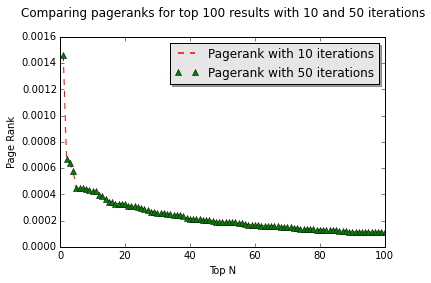

In [22]:
%matplotlib inline 
import matplotlib.pyplot as plt

pr_10 = [ (float(k), v.replace('"', '')) for k, v in (line.split('\t') for line in open('./data/top100_iter10.txt').read().strip().split('\n')) ]
pr_50 = [ (float(k), v.replace('"', '')) for k, v in (line.split('\t') for line in open('./data/top100_iter50.txt').read().strip().split('\n')) ]

x = range(1, 101)

pr_10_y = [pr[0] for pr in pr_10]
pr_50_y = [pr[0] for pr in pr_50]


fig, ax = plt.subplots()
ax.plot(x, pr_10_y, 'r--', label='Pagerank with 10 iterations')
ax.plot(x, pr_50_y, 'g^', label='Pagerank with 50 iterations')
ax.set_title("Comparing pageranks for top 100 results with 10 and 50 iterations\n")
ax.set_ylabel('Page Rank')
ax.set_xlabel('Top N')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.tight_layout()
plt.show()

The top 100 ranked pages did not change between 10 and 50 iterations though some of the pages have their order changed.

***

<h2><span style="color:dodgerblue;font:12px">HW9.4</span></h2>

<span style="color:firebrick; font-size: 120%;"><b>Topic-specific PageRank implementation using MRJob</b></span>

<span style="color:CornflowerBlue ">Run your PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with alpha = 0.85). Run your PageRank implementation on the Wikipedia dataset for 50 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15). Have the top 100 ranked pages changed? Comment on your findings. Plot both 100 curves. <br><br>
Modify your PageRank implementation to produce a topic specific PageRank implementation, as [described](http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf). Run topic specific PageRank on the following randomly generated network of 100 nodes: <br>
s3://ucb-mids-mls-networks/randNet.txt<br>
which are organized into ten topics, as described in the file:<br>
s3://ucb-mids-mls-networks/randNet_topics.txt
<br><br>
Since there are 10 topics, your result should be 11 PageRank vectors (one for the vanilla PageRank implementation in 9.1, and one for each topic with the topic specific implementation). Print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses.</span><br>

<span style="color:cornflowerblue; font-size: 120%;"><b>Preprocessing graph to assign topic to a page and get topic level counts</b></span>

In [8]:
%%writefile preprocess_topic_pagerank.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class MRTopicPageRankPre(MRJob):
    def mapper(self, _, line):
        node, out_links = line.strip().split('\t')
        yield node, ast.literal_eval(out_links)

    def reducer(self, node, out_links):
        for link in out_links:
            if type(link) == dict:
                out_link = str(link)
            else:
                topic = str(link)
        yield node, out_link + "|" + topic

if __name__ == '__main__':
    MRTopicPageRankPre.run()

Overwriting preprocess_topic_pagerank.py


In [29]:
!./preprocess_topic_pagerank.py ./randNet.txt ./randNet_topics.txt -q --no-strict-protocol | sed 's/\"//g' > topic_randNet.txt
!head topic_randNet.txt

1	{'11': 1, '27': 1, '46': 1, '47': 1, '35': 1, '63': 1, '89': 1, '5': 1}|10
10	{'38': 1, '49': 1, '46': 1, '47': 1, '28': 1, '53': 1, '61': 1, '89': 1, '64': 1, '80': 1}|1
100	{'10': 1, '39': 1, '48': 1, '33': 1, '51': 1, '53': 1, '52': 1, '67': 1}|8
11	{'39': 1, '12': 1, '21': 1, '55': 1, '43': 1, '46': 1, '89': 1, '7': 1, '84': 1}|6
12	{'26': 1, '59': 1, '16': 1, '33': 1, '29': 1, '99': 1, '88': 1, '2': 1, '100': 1, '95': 1}|2
13	{'54': 1, '52': 1, '77': 1, '65': 1, '92': 1, '85': 1}|6
14	{'11': 1, '34': 1, '3': 1, '64': 1, '65': 1, '91': 1, '86': 1}|9
15	{'13': 1, '21': 1, '49': 1, '45': 1, '37': 1, '99': 1, '74': 1, '92': 1, '87': 1}|3
16	{'24': 1, '10': 1, '58': 1, '57': 1, '65': 1, '9': 1, '85': 1}|1
17	{'27': 1, '48': 1, '35': 1, '61': 1, '75': 1, '71': 1, '70': 1, '92': 1, '78': 1}|10


In [56]:
!awk -F"\t" '{print $2}' randNet_topics.txt | sort | uniq -c | awk 'BEGIN{OFS="\t"}{print $1, $2}' > topic_counts.txt
!cat topic_counts.txt

17	1
12	10
8	2
9	3
13	4
9	5
6	6
10	7
9	8
7	9


<span style="color:cornflowerblue; font-size: 120%;"><b>Implementation of topic specific page rank</b></span>

$p′ = α (\frac{β}{|Tj|}) + (1−α) ( \frac{m}{|Tj|} + p ) $ *for node in topic Tj* <br>
$p′ = α ( \frac{1-β}{|G|-|Tj|} ) + (1−α) ( \frac{m}{|Tj|} + p ) $ *for node NOT in topic Tj*

In [63]:
%%writefile topicPageRank.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class MRTopicPageRank(MRJob):

    TOPIC_COUNT_LOOKUP = 'topic_counts.txt'
    
    def steps(self):
        return (
                [MRStep(mapper = self.m_pagerank_init)] +
                [
                    MRStep(mapper = self.m_distribute, reducer = self.r_combine_mass),  
                    MRStep(reducer_init = self.topic_counts_init, reducer = self.r_update_pagerank)
                ] * self.options.num_iterations
        )

    # set command line option to accept start and end node
    def configure_options(self):
        super(MRTopicPageRank, self).configure_options()
        self.add_passthrough_option('--num-iterations', default=10, type=int, help='number of iterations to compute stable pagerank')
        self.add_passthrough_option('--N', default=None, type=float, help='total number of webpages (or nodes)')
        self.add_passthrough_option('--d', default=0.85, type=float, help='dampening factor')
        self.add_passthrough_option('--b', default=0.99, type=float, help='beta irreducibility factor (closer to 1)')
        self.add_passthrough_option('--T', default=10, type=int, help='number of topics')

    def topic_counts_init(self):
        #self.topic_counts = { int(topic):int(count) for topic,count in (line.split("\t") for line in open(self.TOPIC_COUNT_LOOKUP).read().strip().split('\n')) }

        self.topic_counts = {}
        for line in open(self.TOPIC_COUNT_LOOKUP).read().strip().split('\n'):
            line = line.split("\t")
            self.topic_counts[int(line[1])] = int(line[0])
        
    # pagerank_init initializes each node with 1/|Tj|,
    # where |Tj| is number of nodes in the graph for a 
    # specific topic (determined in a pre-processing phase)
    def m_pagerank_init(self, _, line):
        node, topic_outlinks = line.split('\t')
        node = node.replace('"', '')
        topic_outlinks = topic_outlinks.replace('"', '')
        out_links, topic = topic_outlinks.split('|')
        pr = [ 1.0 / self.options.N ] * (self.options.T + 1)

        yield node, out_links + "|" + topic + "|" + str(pr)

    #   distribute mass to the outgoing links
    def m_distribute(self, node, pr_out_links):
        # parse input to read page rank of the outgoing links
        out_links, topic, prs = map(ast.literal_eval, pr_out_links.split('|'))
        
        # emit vanilla page rank for each node
        if len(out_links) > 0:
            pr_new = [ pr / len(out_links) for pr in prs ]
            for out_link in out_links:
                yield out_link, pr_new

        # if the node is for dangling (i.e. no outgoing link),
        # emit the loss to redistribute to all the incoming
        # links to the dangling node
        if len(out_links) == 0:
            yield 'dangling', prs

        # recover graph structure
        yield node, pr_out_links

    # update pagerank by combining the mass
    def r_combine_mass(self, node, pr_out_links):
        # initialize loss
        loss = [0] * (self.options.T + 1)

        # if the node is dangling, redistribute the loss
        # to all the nodes in the graph
        if node == 'dangling':
            for dangling in pr_out_links:
                for l in range(len(dangling)):
                    loss[l] += dangling[l]

            for n in range(1, int(self.options.N) + 1):
                yield str(n), loss
        # else combine the mass for the node
        else:
            M = [0] * (self.options.T + 1)
            out_links = {}
            topic = ""

            for pr_out_link in pr_out_links:
                if type(pr_out_link) == list:
                    for l in range(len(pr_out_link)):
                        M[l] += pr_out_link[l]
                else:
                    out_links, topic, prs = map(ast.literal_eval, pr_out_link.split('|'))

            yield node, str(out_links) + "|" + str(topic) + "|" + str(M)
            
    def r_update_pagerank(self, node, pr_out_links):
        loss = [0] * (self.options.T + 1)
        pr_new = []

        # teleportation factor
        a = 1 - self.options.d
        N = self.options.N
        b = self.options.b

        for pr_out_link in pr_out_links:
            if len(pr_out_link) > 0:
                if type(pr_out_link) == list:
                    loss = pr_out_link
                else:
                    out_links, topic, pr = map(ast.literal_eval, pr_out_link.split('|'))

        # update pagerank for each page in topic j
        for j in range(1, self.options.T + 1):
            Tj = self.topic_counts[j-1]
            
            if j-1 == topic:
                pr_new.append(a * (b/Tj) + (1-a) * (loss[j-1]/N + float(pr[j-1])))
            else:
                pr_new.append(a * ((1-b)/(N-Tj)) + (1-a) * (loss[j-1]/N + float(pr[j-1])))

        pr_new.append(a * (1/N) + (1-a) * (loss[j-1]/N + float(pr[j-1])))
                
        yield node, str(out_links) + "|" + str(topic) + "|" + str(pr_new)

if __name__ == '__main__':
    MRTopicPageRank.run()

Overwriting topicPageRank.py


In [27]:
!pwd

/media/sf_shared/GitHub/MIDS-W261-MACHINE-LEARNING-AT-SCALE/week10/hw9


In [59]:
!./topicPageRank.py ./topic_randNet.txt --file ./topic_counts.txt --N=100 --num-iterations=10 -q | sed 's/\"//g' > topic_pr.txt

In [ ]:
!./topicPageRank.py /home/rt/wrk/w261/hw9/part-00000 --file ./topic_counts.txt --N=15192277 --num-iterations=2 -q > topic_pr.txt

In [60]:
import ast

topic_ranks = []
j = 0

for line in open('./topic_pr.txt').read().strip().split('\n'):
    node, pr_out_links = line.split('\t')
    out_links, topic, pr = map(ast.literal_eval, pr_out_links.split('|'))
    
    l = []
    l.extend([int(node), topic])
    for j in range (0, 11):
        l.append(float(pr[j]))
    
    topic_ranks.append(l)
    #print l

for j in range(0, 10):
    print "=" * 30
    print "Top 10 pages under Topic {}".format(j+1)
    print "=" * 30
    for s in sorted(topic_ranks, key=lambda x: x[j+2], reverse=True)[:10]:
        print "{0: <4} {1: <4} {2}".format(s[0], s[1], round(s[j+2], 4))
        
print "=" * 30
print "Top 10 pages - Global Page rank"
print "=" * 30
for s in sorted(topic_ranks, key=lambda x: x[12], reverse=True)[:10]:
    print "{0: <4} {1: <4} {2}".format(s[0], s[1], round(s[12], 4))

Top 10 pages under Topic 1
32   1    0.0206
77   1    0.0205
52   1    0.0198
92   1    0.0195
10   1    0.0186
27   1    0.0185
85   7    0.0178
98   1    0.0177
46   1    0.0175
74   10   0.016
Top 10 pages under Topic 2
58   2    0.0308
71   2    0.0297
9    2    0.0293
73   2    0.0289
12   2    0.0269
59   2    0.0258
75   2    0.0248
82   2    0.0229
52   1    0.0163
17   10   0.0152
Top 10 pages under Topic 3
15   3    0.0315
70   3    0.0271
86   3    0.0265
91   3    0.0245
66   3    0.0241
2    3    0.0237
31   3    0.0228
40   3    0.0222
20   3    0.0197
74   10   0.0159
Top 10 pages under Topic 4
63   4    0.0262
83   4    0.0218
65   4    0.0206
78   4    0.0202
41   4    0.0199
84   4    0.0195
79   4    0.0184
38   4    0.0175
15   3    0.0168
72   4    0.0167
Top 10 pages under Topic 5
99   5    0.029
90   5    0.0283
88   5    0.0272
51   5    0.0268
45   5    0.0256
5    5    0.0239
34   5    0.0239
4    5    0.0234
80   5    0.0228
100  8    0.0167
Top 10 pages unde

<span style="color:cornflowerblue; font-size: 120%;"><b>Results</b></span>

**The result of the topic sensitive page rank is different from global page rank. As evident in topic wise page rank vector, pages associated with a specific topic are ranked higher. However, in certain topics such as Topic 9 and Topic 6 there are other topic related pages that are ranked higher. May be these pages are incorrectly tagged under a topic or they can be classified under both the topics.**

***

<h2><span style="color:dodgerblue;font:12px">HW9.5</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Applying topic-specific PageRank to Wikipedia</b></span>

<span style="color:CornflowerBlue ">Here you will apply your topic-specific PageRank implementation to Wikipedia, defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10, so that there are 10 topics. Once again, print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses.</span><br>

<span style="color:cornflowerblue; font-size: 120%;"><b>Pre-processing wikipedia data set to assign topic to each page</b></span>

In [344]:
%%writefile WikiAssignTopic.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class MRWikiAssignTopic(MRJob):        
    def mapper_init(self):
        # load indices file into memory
        self.lookup = { v1:(len(k)%10) for k, v1, v2, v3 in (line.split("\t") for line in open('indices.txt').read().strip().split('\n')) }
        #for line in open('indices.txt').read().strip().split('\n'):
        #    line = line.split('\t')
        #    key = line[1]
        #    value = len(line[0])%10
        #    self.lookup[key] = value
    
    def mapper(self, _, line):
        node, out_links = line.split("\t")
        yield node, out_links + "|" + str(self.lookup.get(node, 0))
    
if __name__ == '__main__':
    MRWikiAssignTopic.run()

Overwriting WikiAssignTopic.py


In [346]:
%%writefile WikiAssignTopic.py
#!/usr/bin/python
from mrjob.job import MRJob

class MRWikiAssignTopic(MRJob):
    SORT_VALUES = True

    def mapper(self, _, line):
        splits = line.split("\t")

        if len(splits) == 2:
            symbol = 'B'
            node, out_links = splits
            yield node, [symbol, out_links]
        else:
            symbol = 'A'
            topic = len(splits[0])%10
            node = splits[1]
            yield node, [symbol, topic]

    def reducer(self, key, values):
        topics = []

        for value in values:
            if value[0] == 'A':
                topics.append(value)
            if value[0] == 'B':
                for topic in topics:
                    yield key, value[1] + "|" + str(topic[1])

if __name__ == '__main__':
    MRWikiAssignTopic.run()

Overwriting WikiAssignTopic.py


In [340]:
!./WikiAssignTopic.py /home/rt/wrk/w261/hw9/PageRank-test_indexed.txt --file="/home/rt/wrk/w261/hw9/lkp.txt" --q

"2"	"{'3': 1}|4"
"3"	"{'2': 1}|9"
"4"	"{'1': 1, '2': 1}|8"
"5"	"{'4': 1, '2': 1, '6': 1}|3"
"6"	"{'2': 1, '5': 1}|1"
"7"	"{'2': 1, '5': 1}|0"
"8"	"{'2': 1, '5': 1}|9"
"9"	"{'2': 1, '5': 1}|7"
"10"	"{'5': 1}|1"
"11"	"{'5': 1}|5"


In [351]:
%%writefile run_wikiassigntopic_emr.py
#!/usr/bin/python
import time
import sys
from WikiAssignTopic import MRWikiAssignTopic

# read source file, start and end nodes
SOURCE = sys.argv[1]
TARGET = sys.argv[2]
LOOKUP = sys.argv[3]

start_time = time.time()
print "processing file {}".format(SOURCE)

# run on emr
mr_job = MRWikiAssignTopic(
    args=[
        SOURCE, LOOKUP,
        '-r', 'emr', 
        '--pool-emr-job-flows', 
        '--max-hours-idle', '1', 
        '--pool-name', 'jobpool_hw9_rt', 
        '--output-dir', TARGET, 
        '-q', 
        '--no-output', 
        '--no-strict-protocol',
        '--ec2-instance-type', 'm1.large'
    ])

with mr_job.make_runner() as runner: 
    runner.run()

end_time = time.time()

print "Time taken to assign random topic to wikipedia pages = {:.2f} seconds".format(end_time - start_time)

Overwriting run_wikiassigntopic_emr.py


In [352]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/ --recursive

# run emr
!./run_wikiassigntopic_emr.py "s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt" "s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/" "s3://ucb-mids-mls-networks/wikipedia/indices.txt"

delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/_SUCCESS
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00009
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00010
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00000
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00001
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00002
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00003
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00006
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00004
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00007
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00005
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00008
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00012
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00013
delete: s3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/part-00014
delete: s3:/

In [31]:
# get topic level counts locally
!awk -F"\t" '{print length($1)%10}' /home/rt/wrk/w261/hw9/indices.txt | sort | uniq -c > ./topic_counts.txt

In [45]:
!cat ./topic_counts.txt

1454304	0
1565886	1
1597694	2
1613693	3
1612057	4
1550786	5
1506073	6
1465969	7
1411620	8
1414195	9


<span style="color:cornflowerblue; font-size: 120%;"><b>Running topic PageRank on Wikipedia data set on EMR</b></span>

In [34]:
%%writefile run_topic_pagerank_emr.py
#!/usr/bin/python
import time
import sys
from topicPageRank import MRTopicPageRank

# read source file, start and end nodes
SOURCE = sys.argv[1]
TARGET = sys.argv[2]
LOOKUP = sys.argv[3]
N = sys.argv[4]
ITER = sys.argv[5]

start_time = time.time()
print "processing file {}".format(SOURCE)

# run on emr
mr_job = MRTopicPageRank(
    args=[
        SOURCE, 
        '--output-dir', TARGET, 
        '--file', LOOKUP,
        '--N', N,
        '--num-iterations', ITER,
        '-r', 'emr', 
        '--pool-emr-job-flows', 
        '--max-hours-idle', '1', 
        '--pool-name', 'jobpool_hw9_rt', 
        '-q', 
        '--no-output', 
        '--no-strict-protocol'
    ])

with mr_job.make_runner() as runner: 
    runner.run()

end_time = time.time()

print "Time taken to determoine topicwise pagerank for wikipedia pages = {:.2f} seconds".format(end_time - start_time)

Overwriting run_topic_pagerank_emr.py


In [ ]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw9/wiki/topic/ --recursive

# run EMR
# <script> <source> <target> <number-of-nodes> <number-of-iterations>
!./run_topic_pagerank_emr.py 's3://ucb-mids-mls-rajeshthallam/hw9/wiki/input/' 's3://ucb-mids-mls-rajeshthallam/hw9/wiki/topic/' '/media/sf_shared/GitHub/MIDS-W261-MACHINE-LEARNING-AT-SCALE/week10/hw9/topic_counts.txt' 15192277 10

In [128]:
!aws s3 ls s3://ucb-mids-mls-rajeshthallam/hw9/wiki/topic/ --recursive

2015-11-09 23:01:27          0 hw9/wiki/topic/_SUCCESS
2015-11-09 23:01:27  524572060 hw9/wiki/topic/part-00000
2015-11-09 23:06:53  525071775 hw9/wiki/topic/part-00001
2015-11-09 23:13:01  524109377 hw9/wiki/topic/part-00002
2015-11-09 23:18:48  524789916 hw9/wiki/topic/part-00003
2015-11-09 23:24:34  524676952 hw9/wiki/topic/part-00004
2015-11-09 23:30:31  524324903 hw9/wiki/topic/part-00005
2015-11-09 23:36:24  525214318 hw9/wiki/topic/part-00006
2015-11-09 23:42:09  524580752 hw9/wiki/topic/part-00007
2015-11-09 23:48:10  524154384 hw9/wiki/topic/part-00008
2015-11-09 23:54:05  523932550 hw9/wiki/topic/part-00009
2015-11-09 23:59:56  524356774 hw9/wiki/topic/part-00010
2015-11-10 00:05:51  524435117 hw9/wiki/topic/part-00011


<span style="color:cornflowerblue; font-size: 120%;"><b>Top 10 PageRanks per Topic</b></span>

In [84]:
import sys
import ast

count = 0
top_100 = []
[top_100.append([]) for x in range(12)]

pr_agg = [0] * 11

for i in range(12):
    fn = "%05d" % i
    with open('/home/rt/wrk/w261/hw9/topic/part-{}'.format(fn)) as f:
        print "part-{}".format(fn)
        for line in f:
            node, pr_out_links = line.split('\t')
            node = node.replace('"', '')
            pr_out_links = pr_out_links.replace('"', '')
            pr = ast.literal_eval((pr_out_links.split('|')[2]))

            for j in range(len(pr)):
                pr_agg[j] += pr[j]
                if len(top_100[0]) < 100:
                    top_100[j].append((pr[j], node))
                    top_100[j].sort(reverse=True)
                else:
                    if pr[j] > top_100[j][-1][0]:
                        top_100[j][-1] = (pr[j], node)
                        top_100[j].sort(reverse=True)

part-00000
part-00001
part-00002
part-00003
part-00004
part-00005
part-00006
part-00007
part-00008
part-00009
part-00010
part-00011


In [91]:
lookup = { v1:k.replace("'", "") for k, v1, v2, v3 in (line.split("\t") for line in open('/home/rt/wrk/w261/hw9/indices.txt').read().strip().split('\n')) }

In [127]:
for topic in range(10):
    print "=" * 30
    print "Top 10 pages under Topic {}".format(topic+1)
    print "=" * 30

    for j in range(11):
        print lookup[top_100[topic][j][1]]

print "=" * 30
print "Top 10 pages - Global Page rank"
print "=" * 30
for j in range(11):
    print lookup[top_100[10][j][1]]
print "=" * 30

Top 10 pages under Topic 1
United States
Animal
France
Germany
Arthropod
Insect
Canada
List of sovereign states
United Kingdom
India
England
Top 10 pages under Topic 2
United States
Animal
France
Germany
Canada
Arthropod
United Kingdom
Insect
England
India
List of sovereign states
Top 10 pages under Topic 3
United States
Private Use Areas
Animal
France
Hangul
Germany
Canada
United Kingdom
England
India
Arthropod
Top 10 pages under Topic 4
United States
France
Animal
Germany
Canada
United Kingdom
England
List of sovereign states
India
Arthropod
Insect
Top 10 pages under Topic 5
United States
France
Animal
Germany
Canada
List of sovereign states
United Kingdom
England
India
Arthropod
Insect
Top 10 pages under Topic 6
United States
France
Animal
Germany
List of sovereign states
Canada
Arthropod
United Kingdom
India
Insect
England
Top 10 pages under Topic 7
United States
Animal
France
Germany
List of sovereign states
Arthropod
Insect
Canada
India
United Kingdom
Iran
Top 10 pages under Topi

<span style="color:firebrick">** -- END OF ASSIGNMENT 9 -- **</span>